# Heuristic Optimization - Variable selection with the harmony algorithm

Maximilian Zebhauser - 02.12.2018

In [2]:
# Packages
import random as random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math as math
import sklearn.metrics as metrics
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

## Motivation
Obtaining the optimal subset $x_m$ of the feature matrix $\Phi_{n,p}$ is a computationally hard problem in the case $\Phi{n,p}$ has a large number of columns $p$. To examine all possible solutions for this problem by brute force has the complexity $\binom{p}{m}$. To examine all possible subsets and combinations of the features has complexity $2^{p}$. To avoid computational overload, there exist methods like orthogonal design, penalized likelihood or heuristic optimization amongst others. This analysis is focused on the latter case. The basic heuristic approach is to apply an iterative method starting with an empty model (stepwise forward) and improve the model by adding features based on an evaluation criterion.

In general heuristic optimization procedures use iterative methods to approximate an optimum. The goal is to efficiently explore the search space in order to find near–optimal solutions. One branch within these algorithms are the evolutionary algorithms, which are inspired by natural processes. The harmony search algorithm (HS) also belongs to this group. It can be applied to various fields ranging from robotics to engineering. It is based on the principles of improvising jazz musicians, where each input variable refers to one muscician with the overall goal of creating an optimal harmony. The algorithm was proposed by Geem et al. in 2001. 

Throughout this analysis I will explain the general mechanics of the HS algorithm and how it applies to the previously  mentioned variable selection problem. There will be two applications of the algorithm. In the first case, the algorithm has to identify the generating features within an artificial dataset. In a second case, the HS algorithm has to identify an optimal subset of features to classify and then predict high income individuals.

## General mechanics of the harmony search algorithm
The HS is a heuristic optimization method imitating the music improvisation. The algorithm can be used in both cases minimization and maximization. Without loss of generality and for the ease of understanding, this chapter shows the pseudocode and the implementation of the algorithm in the case of minimizing a function. Later, when adapting the algorithm for the variable selection problem both options will be built into the function. 

The main components are of HS are the following: the harmonic memory (HM), the memory consideration rate (HMCR) and the pitch adjusting rate (PAR). The HM accounts for the fact that musicians can choose from previosly tested melodies, as they do not have to built up a new melody entirely from scratch each improvisation. The harmony memory size (HMS) defines the amount of previously tested notes a musician can choose from. The PAR takes into account that musicians can slighly modify the notes to create a even better melody. So, each improvisation the musician chooses a known, a known but slightly modified or a random note. In the end, the notes form all musicians in the ensable form a melody or harmony which will be evaluated. Depending on the evaluation and wheather the harmony should be remembered for future improvisations, it will be stored in the HM.

In the context of the algorithom, each musician translates into one feature of $\Phi$ spanning the columns of HM. The number of rows represent the HMS, storing possible solutions for the minimization problem. It has the following form:

$$
HM_{hms,p} = 
\begin{bmatrix} 
{ x _ { 1 } ^ { 1 } } & { x _ { 2 } ^ { 1 } } & { \dots } & { x _ { p } ^ { 1 } } \\ { x _ { 1 } ^ { 2 } } & { x _ { 2 } ^ { 2 } } & { \dots } & { x _ { p } ^ { 2 } } \\ { \vdots } & { \vdots } & { \ddots } & { \vdots } \\ { x _ { 1 } ^ { \mathrm { hms } } } & { x _ { 2 } ^ { \mathrm { hms } } } & { \ldots } & { x _ { p } ^ { \mathrm { hms } } } 
\end{bmatrix}
$$

To evaluate the possible solutions one has to define a function $f(x)$ which evaluates the possible solutions stored in the HM. This function is also called the fitness function, which is a usual notation in the branch of evolutionary algorithms. The final goal is to minimize the fitness function $f_{fitness}(x)$. These results are stored in a vector which has the following properties: 

$$
HM_{fitness} = 
\begin{bmatrix} 
{ f \left( \mathbf { x } ^ { 1 } \right) } \\ { f \left( \mathbf { x } ^ { 2 } \right) } \\ { \vdots } \\ { f \left( \mathbf { x } ^ { \mathrm { HMS } } \right) } 
\end{bmatrix}
$$

The HMCR and the PAR are two probability thresholds, where $p_{hmcr}$ is the probability to remember a note from the HM for a specifix $x_p$. The probability $p_{par}$ imitates the ability of a musician to slightly modify a note within a defined variation bandwidth $(b_w)$. Additional parameters for the algorithm are lower and upper bounds for each feature in $\Phi$ $(LB_p, UB_p)$ and the number of improvisations $(N_i)$ or iterations respectively. The algorithm stops as soon as the number of maximum iterations is reached. It is also possible to additionally set a convergence criterion, one could use the standard deviation evaluating range of the $HM_{fitness}$ to account for convergence. 

The general mechanics of the algorithm can be summarized as follows: 
1. Initialize the algorithm's parameter for the specific problem
2. Find a new harmony, where each musician has to find a value with the following characteristics: 
    1. Pick a existing value from the HM with probability HMCR:
        1. Keep value as is with probability: (1 - PAR)
        2. Slightly modify the value with probability: PAR
    2. Pick a random value within the varible's specific bandwith
3. Evaluate wheather the new harmony is added to the HM using the fitness function
4. Iterate over steps two and three until the maximum number of improvisations or a convergence criterion is met

Which leads to the following pseudo-code in the minimization case:

<img src="03_Pseudocode/Pseudo.png" style="float: left; width: 50%;"> 

The implementation looks like the following, with default values as seen in the literature:

In [3]:
def harmony_search(hm_s, hm_p, function, LB, UB, PAR = 0.3, HMCR = 0.9, NI = 10000, 
                   seed = 10, bw = 0.01, std = .001):    
    np.random.seed(seed); c = 0
    bw = bw * (abs(min(LB)) + abs(max(UB)))
    HM = np.zeros(shape=(hm_s,hm_p))
    for p in range(0,hm_p): 
        HM[::,p] = np.random.uniform(LB[p],UB[p], hm_s)
    HM_fitness = list(np.apply_along_axis(function,1,HM))
    while c < NI: 
        x = np.zeros(shape=(hm_p))
        for p in range(0,hm_p):
            if np.random.uniform(low= 0, high=1) <= HMCR: 
                j = np.random.randint(0,(hm_s),1)
                x[p] = HM[j,p]
                if np.random.uniform(low= 0, high=1) <= PAR:
                    x[p] = x[p] + np.random.uniform(low= -1, high=1) * bw
            else: 
                x[p] = np.random.uniform(LB[p],UB[p], 1)
        if (max(HM_fitness) > function(x)):
            wh = HM_fitness.index(max(HM_fitness))
            HM[wh,0:hm_p] = x
            HM_fitness[wh] = function(x)
        else: 
            pass
        c += 1
        if np.std(HM_fitness) < std: 
            break
    return HM, HM_fitness, c

This simple example should just be a quick sanity check to explore wheather the algorithm works as expected. The problem is to minimize the following function: $f_{fitness}(x) = |x|$, which is a convex function and not differntiable at the minimum. In our example the function maps from $R^5$ to $R$.

In [4]:
def example_function(x):
    return sum(abs(x))
HMS2, HMS_fitness1, c1 = harmony_search(20, 5, example_function, [-3] * 5, [3] * 5)
print("Convergence after " + str(c1) + " iterations, with a minimum of the fitness function at approximately: " + 
      str(round(np.mean(HMS_fitness1),3)))

Convergence after 1847 iterations, with a minimum of the fitness function at approximately: 0.008


## The harmony search algorithm in the context of feature selection
As stated earlier, in the case of variable selection, it is of interest to find an optimal subset $x_m$ of $\Phi$. Therefore, the algorithm now has to make the descision wheather a specific variable enters into the model or not: each $x_{p}^{hms} \in [0, 1] $. The evaluation at each iteration is based on hyperparameters calculated by fitting the proposed model. As the varibles are binary instead of continous the algorithm has to be slightly adapted as well. Firstly, there is no need to define the lower and upper bounds for the binary variables in the HM. Secondly, the binary setting does not require the parameter modification bandwidth. In case the PAR criterion is met, the contrary binary output is chosen. Additionally, the algorithm can handle maximization or minimization depending on the fitness function $f_{fitness}(x)$. A detailed discussion of $f_{fitness}(x)$ and the data used is found below.

The adapted implementation of the HS algorithm according to the needs of variable selection:

In [5]:
def adapted_harmony_search(hm_s, hm_p, function, PAR = 0.3, HMCR = 0.9, NI = 10000, seed = None, 
                           maximize = False, std = .01):    
    if seed != None:
        np.random.seed(seed) 
    c = 0
    HM = np.zeros(shape=(hm_s,hm_p))
    for p in range(0,hm_p):
        HM[::,p] = np.random.randint(0,2, hm_s)
    HM_fitness = list(np.apply_along_axis(function,1,HM))
    while c < NI: 
        x = np.zeros(shape=(hm_p))
        for p in range(0,hm_p):
            if np.random.uniform(low= 0, high=1) <= HMCR: 
                j = np.random.randint(0,(hm_s),1)
                x[p] = HM[j,p]
                if np.random.uniform(low= 0, high=1) <= PAR:
                    x[p] = (0 if x[p] else 1)
            else: 
                x[p] = np.random.randint(0,2,1)
        f_x = function(x)
        if maximize: 
            if (min(HM_fitness) < f_x):
                wh = HM_fitness.index(min(HM_fitness))
                HM[wh,0:hm_p] = x
                HM_fitness[wh] = f_x
            else: 
                pass
        else: 
            if (max(HM_fitness) > f_x):
                wh = HM_fitness.index(max(HM_fitness))
                HM[wh,0:hm_p] = x
                HM_fitness[wh] = f_x
            else: 
                pass
        c += 1
        if np.std(HM_fitness) < std: 
            break
    return HM, HM_fitness, c

### HM feature selection - artificial dataset
In a first application, the algorithm should proof that it captures all the features which generate an observed process. The process of variable selection is especially intersting and challanging as the number of features $p$ grows and at the same time a low number of observations $n$ is available. In these cases variable selection is a crucial part of the modeling activities.

#### Observations > Features
To control for the data generating process the dataset is created artifically. In a first step the number of features $p$ varying from 20 to 100, the number of observations will be hold at 100 constantly and 20% of the features will serve for generating the dependant variable. In this setting standard OLS can be used. In this setting it is possible to evaluate the performance of the algorithm. In this step we are not yet interested in the predictional power of any model.  

In particular the test will involve three different settings of the HS: standard as seen in the literature, high probability for random selection and high probability for pitch adjustment. Each iteration a average over 25 results of the HS will be considered. Additionally the number of improvisations will be varied from 10 to 5000, a higher number of iterations leads to a higher calculation time. In one test run, the results significantly improved at 10.000 iterations for a large number of features. 

To compare the information contained in different models, Kullback-Leibler Information criterion could be used as the full reality is known in the artificial case. To make the simulation as realistic as possible, the widley used AIC will serve as fitness function. The AIC is an estimator for the Kullback-Leibler Information and is easy to compute in the least squares case. It assumes that the maximized log-likelihood is a biased estimator, where the bias is equal to the number of parameters to estimate the model. Without loss of generality, the for small sample sizes corected $AIC_c$ will be used as by Burnham and Anderson proposed (rule of thumb: $AIC_c$ if n/k ≤ 40). The $AIC_c$ penalizes the number of variables included in the model higher to minimize overfitting and it converges to the $AIC$ as sample size grows:

$$
AIC_c = AIC + \frac { 2 k ( k + 1 ) } { n - k - 1 }
$$

Let us have a look how the fitness function or the $AIC_c$ respectively behaves. For this purpose we grow the model iteratively starting with the generating features. The expectation would be that we hit the same value as the true model as soon as we have included all generating features and increase the value from that point onwards. This behaviour is validated in the first two plots seen below. In the third plot we clearly see that the $AIC_c$ starts missbehaving as soon as the number of features exceeds the number of observations. The reason for that behaviour is obvious as the OLS model does not converge in these cases. This case will be revisited later in the analysis. 

The results extracted from the tables below show clearly that the number of improvisations have a positive impact on the performance of the HS algorithm with respect to both the full model size and detection of generating features. The standard parametrization for the probability thresholds PAR and HMCR seem to work best as well. In this standard setting, the benchmark model Lasso outperforms the HS in average detection rate, full model size and running time. 

In [5]:
# Definition of the fitness function
def get_fitness(indicator):
    try: 
        indicator = [x==1 for x in indicator]
        k = sum(indicator)
        result = sm.OLS(y_art,X_art[::, indicator],hasconst=False).fit()
        AIC = result.aic
        return (AIC + (2*k*(k+1))/(n-k-1))
    except: 
        return 10000000

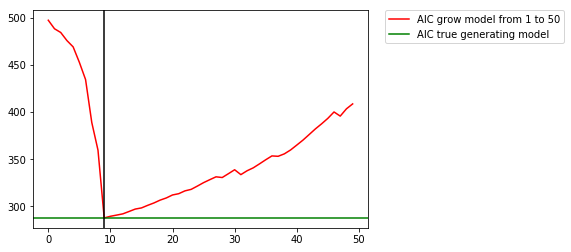

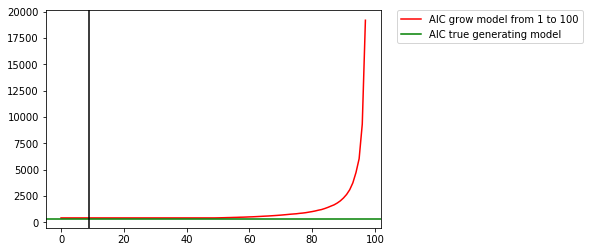

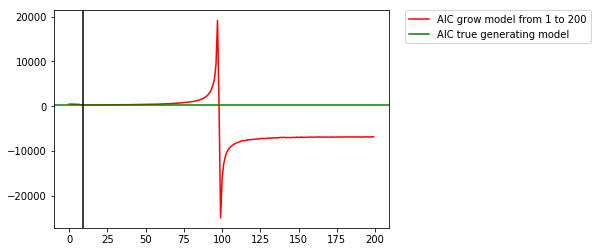

In [6]:
np.random.seed(10)
n = 100
p = 200
real_p = 10
X_art = np.ndarray(shape = (n, p), buffer = np.random.normal(size = n*p))
y_art = np.apply_along_axis(sum,1,X_art[::,0:real_p]) + np.random.normal(size = n)

feat = [False] * p
feat[0:real_p] = [True] * real_p
truemodel= (get_fitness(feat))

feat = [False] * p
IAC50 = []
for i in range(1, (50 +1)):
    feat[i-1] = True
    IAC50.append(get_fitness(feat))
IAC100 = []
for i in range(1, (98 +1)):
    feat[i-1] = True
    IAC100.append(get_fitness(feat))
feat = [False] * p
IAC200 = []
for i in range(1, (200 +1)):
    feat[i-1] = True
    fitness = get_fitness(feat)
    if fitness <10000000:
        IAC200.append(fitness)
    else: 
        IAC200.append(0)

fig, ax = plt.subplots() 
plt.plot(list(range(0,len(IAC50))),IAC50, label= "AIC grow model from 1 to 50", color='r')
plt.axhline(y=truemodel, label= "AIC true generating model", color='g')
plt.axvline(x=real_p - 1, color='k')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
fig, ax = plt.subplots() 
plt.plot(list(range(0,len(IAC100))),IAC100, label= "AIC grow model from 1 to 100", color='r')
plt.axhline(y=truemodel, label= "AIC true generating model", color='g')
plt.axvline(x=real_p - 1, color='k')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
fig, ax = plt.subplots() 
plt.plot(list(range(0,len(IAC200))),IAC200, label= "AIC grow model from 1 to 200", color='r')
plt.axhline(y=truemodel, label= "AIC true generating model", color='g')
plt.axvline(x=real_p - 1, color='k')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [7]:
np.random.seed(10)
n = 100
#################### 
# Changing number of iterations for HS heavyly impacts computing time \ this setting takes about 2h
improvisations = [10, 50, 100, 150, 200, 1000, 5000]
####################
for impros in improvisations: 
    HMS_right = []
    HMS_total = []
    HMS1_right = []
    HMS1_total = []
    HMS2_right = []
    HMS2_total = []
    lasso_right = []
    lasso_total = []
    p_s = range(20,101,20)
    for p in p_s: 
        real_p = [False, False, False, False, True] * int(p/ 5)
        random.shuffle(real_p)
        X_art = np.ndarray(shape = (n, p), buffer = np.random.normal(size = n*p))
        y_art = np.apply_along_axis(sum,1,X_art[::,real_p]) + np.random.normal(size = n)
        rp = []
        tp = []
        for tests in range(1,25):
            HM_test, HM_fitness_test, c_test = adapted_harmony_search(10, p, get_fitness, NI = impros)
            rp.append(sum(HM_test[HM_fitness_test.index(min(HM_fitness_test))][real_p])/ sum(real_p))
            tp.append(sum(HM_test[HM_fitness_test.index(min(HM_fitness_test))]) / p)
        HMS_right.append(round(np.mean(rp),2))
        HMS_total.append(round(np.mean(tp),2))
        rp = []
        tp = []
        for tests in range(1,25):
            HM_test, HM_fitness_test, c_test = adapted_harmony_search(10, p, get_fitness, NI = impros,HMCR = 0.1)
            rp.append(sum(HM_test[HM_fitness_test.index(min(HM_fitness_test))][real_p])/ sum(real_p))
            tp.append(sum(HM_test[HM_fitness_test.index(min(HM_fitness_test))]) / p)
        HMS1_right.append(round(np.mean(rp),2))
        HMS1_total.append(round(np.mean(tp),2))
        rp = []
        tp = []
        for tests in range(1,25):
            HM_test, HM_fitness_test, c_test = adapted_harmony_search(10, p, get_fitness, NI = impros, PAR = 0.9)
            rp.append(sum(HM_test[HM_fitness_test.index(min(HM_fitness_test))][real_p])/ sum(real_p))
            tp.append(sum(HM_test[HM_fitness_test.index(min(HM_fitness_test))]) / p)
        HMS2_right.append(round(np.mean(rp),2))
        HMS2_total.append(round(np.mean(tp),2))
        lasso = sm.OLS(y_art,X_art,hasconst=False).fit_regularized(alpha = .1, L1_wt=1, refit =True)
        lasso_right.append(round(sum((lasso.params > 0)[real_p]) / sum(real_p) , 2))
        lasso_total.append(round(sum(lasso.params > 0) / p , 2))
    results= pd.DataFrame({'HS_standard_right': HMS_right, 'HS_standard_total': HMS_total, 
                               'HS_lowHMCR_right': HMS1_right, 'HS_lowHMCR_total': HMS1_total, 
                               'HS_highPAR_right': HMS2_right, 'HS_highPAR_total': HMS2_total,
                               'Lasso_right': lasso_right, 'Lasso_total': lasso_total}, index = list(p_s))
    display(results)

,HS_standard_right,HS_standard_total,HS_lowHMCR_right,HS_lowHMCR_total,HS_highPAR_right,HS_highPAR_total,Lasso_right,Lasso_total
20,0.94,0.54,0.94,0.54,0.88,0.55,1.0,0.25
40,0.80,0.55,0.85,0.56,0.85,0.57,1.0,0.20
60,0.73,0.52,0.72,0.52,0.74,0.53,1.0,0.27
80,0.66,0.48,0.65,0.48,0.66,0.48,1.0,0.24
100,0.60,0.46,0.58,0.46,0.58,0.46,1.0,0.29


,HS_standard_right,HS_standard_total,HS_lowHMCR_right,HS_lowHMCR_total,HS_highPAR_right,HS_highPAR_total,Lasso_right,Lasso_total
20,1.00,0.49,0.99,0.54,0.97,0.57,1.0,0.35
40,0.91,0.55,0.86,0.54,0.84,0.57,1.0,0.22
60,0.85,0.54,0.78,0.52,0.77,0.52,1.0,0.27
80,0.76,0.49,0.74,0.50,0.71,0.51,1.0,0.28
100,0.59,0.43,0.61,0.45,0.58,0.46,1.0,0.26


,HS_standard_right,HS_standard_total,HS_lowHMCR_right,HS_lowHMCR_total,HS_highPAR_right,HS_highPAR_total,Lasso_right,Lasso_total
20,1.00,0.48,1.00,0.50,0.98,0.61,1.0,0.40
40,0.97,0.58,0.93,0.56,0.82,0.53,1.0,0.25
60,0.86,0.53,0.81,0.52,0.72,0.49,1.0,0.42
80,0.80,0.51,0.72,0.46,0.70,0.49,1.0,0.30
100,0.63,0.44,0.62,0.45,0.60,0.46,1.0,0.29


,HS_standard_right,HS_standard_total,HS_lowHMCR_right,HS_lowHMCR_total,HS_highPAR_right,HS_highPAR_total,Lasso_right,Lasso_total
20,1.00,0.45,1.00,0.50,0.99,0.59,1.00,0.30
40,0.99,0.56,0.94,0.57,0.83,0.53,1.00,0.30
60,0.93,0.55,0.85,0.54,0.79,0.53,1.00,0.25
80,0.84,0.50,0.79,0.51,0.71,0.50,1.00,0.26
100,0.70,0.47,0.66,0.47,0.60,0.46,0.95,0.28


,HS_standard_right,HS_standard_total,HS_lowHMCR_right,HS_lowHMCR_total,HS_highPAR_right,HS_highPAR_total,Lasso_right,Lasso_total
20,1.00,0.41,1.00,0.46,0.98,0.55,1.0,0.20
40,1.00,0.52,0.96,0.56,0.85,0.56,1.0,0.25
60,0.94,0.55,0.85,0.56,0.79,0.53,1.0,0.22
80,0.82,0.50,0.76,0.49,0.67,0.48,1.0,0.29
100,0.68,0.44,0.63,0.45,0.58,0.46,1.0,0.30


,HS_standard_right,HS_standard_total,HS_lowHMCR_right,HS_lowHMCR_total,HS_highPAR_right,HS_highPAR_total,Lasso_right,Lasso_total
20,1.00,0.36,1.00,0.45,1.00,0.52,1.00,0.45
40,1.00,0.49,0.99,0.55,0.87,0.56,1.00,0.28
60,1.00,0.55,0.92,0.57,0.82,0.56,1.00,0.25
80,0.95,0.52,0.85,0.51,0.75,0.51,1.00,0.29
100,0.77,0.44,0.72,0.45,0.62,0.45,0.95,0.31


,HS_standard_right,HS_standard_total,HS_lowHMCR_right,HS_lowHMCR_total,HS_highPAR_right,HS_highPAR_total,Lasso_right,Lasso_total
20,1.00,0.38,1.00,0.41,1.00,0.50,1.0,0.45
40,1.00,0.44,1.00,0.51,0.91,0.58,1.0,0.22
60,1.00,0.47,0.98,0.56,0.84,0.53,1.0,0.28
80,0.99,0.51,0.89,0.51,0.71,0.49,1.0,0.29
100,0.88,0.48,0.74,0.46,0.65,0.46,1.0,0.30


#### Observations < Features
In the second part of this chapter, the analysis is focused on the cases where the number of features exceeds the number of observations. A first approach using HS with a divide and conquer approach did not work as expected. The idea was to split the data such that the number of features is smaller than the number of observations by using all observations but only a subset of features in each sub-dataset. Then, recursively merge the features which tend to contribute positively to the goodness of fit.

As a consequence the fitness function needs to be updated as OLS does not converge in these cases as stated earlier. As Lasso's performance also decreases in these cases, the approach would be to combine both methods with a moderate penalization for Lasso. To account for features which are not considered by Lasso but are considered by HS $(k_{wrong})$, we have to extend the penalization of $AIC_c$ to the following:

$$
AIC_{Lasso} = AIC_c + 4k_{wrong}
$$

For computational reasons, the eavaluation was limited to 200 improvisation and the standard setting for HS's parameters. The results extracted from the tables below show that a combination of both methods deliver best results given the settings. Above a certain number of features the results get somewhat fuzzy and need further research with a higher number of improvisations. 

In [8]:
# Updating the fitness function
def get_fitness(indicator):
    try: 
        indicator = [x==1 for x in indicator]
        k = sum(indicator)
        result = sm.OLS(y_art,X_art[::, indicator],hasconst=False).fit_regularized(alpha = .5, L1_wt=1, refit =True)
        AIC = result.aic
        k_wrong = sum(np.isnan(result.pvalues))
        return (AIC + (4 * k_wrong) + ((2*k*(k+1))/abs(n-k-1)))
    except: 
        return 10000000

In [ ]:
np.random.seed(10)
n = 100
#################### 
# Changing number of iterations for HS heavyly impacts computing time \ this setting takes about 8h
improvisations = [10, 50, 100, 150, 200]
####################
for impros in improvisations: 
    HMS_right = []
    HMS_total = []
    lasso_right = []
    lasso_total = []
    p_s = range(100, 401, 50)
    for p in p_s:
        real_p = [False, False, False, False, True] * int(p/ 5)
        random.shuffle(real_p)
        X_art = np.ndarray(shape = (n, p), buffer = np.random.normal(size = n*p))
        y_art = np.apply_along_axis(sum,1,X_art[::,real_p]) + np.random.normal(size = n)
        rp = []
        tp = []
        for tests in range(1,25):
            HM_test, HM_fitness_test, c_test = adapted_harmony_search(10, p, get_fitness, NI = impros)
            rp.append(sum(HM_test[HM_fitness_test.index(min(HM_fitness_test))][real_p])/ sum(real_p))
            tp.append(sum(HM_test[HM_fitness_test.index(min(HM_fitness_test))]) / p)
        HMS_right.append(round(np.mean(rp),2))
        HMS_total.append(round(np.mean(tp),2))
        lasso = sm.OLS(y_art,X_art,hasconst=False).fit_regularized(alpha = .1, L1_wt=1, refit =True)
        lasso_right.append(round(sum((lasso.params > 0)[real_p]) / sum(real_p) , 2))
        lasso_total.append(round(sum(lasso.params > 0) / p , 2))
    results= pd.DataFrame({'HS_standard_right': HMS_right, 'HS_standard_total': HMS_total, 
                               'Lasso_right': lasso_right, 'Lasso_total': lasso_total}, index = list(p_s))
    display(results)

,HS_standard_right,HS_standard_total,Lasso_right,Lasso_total
100,0.53,0.42,1.00,0.29
150,0.43,0.42,0.90,0.29
200,0.45,0.47,0.78,0.26
250,0.58,0.56,0.64,0.23
300,0.53,0.52,0.52,0.16
350,0.52,0.50,0.50,0.16
400,0.47,0.46,0.30,0.15


,HS_standard_right,HS_standard_total,Lasso_right,Lasso_total
100,0.57,0.41,1.00,0.27
150,0.44,0.40,0.97,0.29
200,0.45,0.43,0.80,0.24
250,0.59,0.58,0.54,0.21
300,0.57,0.53,0.60,0.21
350,0.51,0.49,0.47,0.16
400,0.46,0.46,0.39,0.14


,HS_standard_right,HS_standard_total,Lasso_right,Lasso_total
100,0.54,0.39,1.00,0.27
150,0.40,0.38,0.93,0.30
200,0.44,0.41,0.70,0.23
250,0.61,0.59,0.68,0.23
300,0.54,0.53,0.40,0.17
350,0.51,0.48,0.44,0.17
400,0.50,0.45,0.39,0.14


,HS_standard_right,HS_standard_total,Lasso_right,Lasso_total
100,0.50,0.37,0.95,0.23
150,0.40,0.37,0.87,0.28
200,0.42,0.39,0.95,0.28
250,0.63,0.59,0.60,0.22
300,0.56,0.52,0.55,0.18
350,0.51,0.48,0.36,0.16
400,0.48,0.45,0.29,0.12


,HS_standard_right,HS_standard_total,Lasso_right,Lasso_total
100,0.57,0.38,1.00,0.26
150,0.45,0.36,0.97,0.26
200,0.39,0.38,0.75,0.26
250,0.62,0.59,0.82,0.23
300,0.55,0.53,0.53,0.21
350,0.50,0.48,0.39,0.15
400,0.48,0.45,0.40,0.14


### HM feature selection - Predicting Income Group

#### Data Description
The data is obtained from the UCI machine learning repository. It is a extraction from the 1994 US census database and contains over 30.000 observations with charachteristics on individual basis. It is labelled data, as every individual is assigned to an income group with the threshold of 50k USD. From a first check we can see that roughly 32% of the individuals earn more than the 50k USD threshold. The procedure used in further analysis is supervised learning. The data needs some preperation before the modeling activities can start. In a first step, missing values will be removed and the variables will be relabelled as necessary. Aditionally we standardize the continous variables. Secondly, dummy variables will be created for categorical variables. Then we check for feature correlation, which tend to be low amongst all features.

In [6]:
income_data = pd.read_csv("./02_Data/adult_data.txt",header = None)
income_data.columns =  ["age","workclass","fnlwgt","education","education_num","marital_status",
                        "occupation","relationship","race","sex","capital_gain","capital_loss",
                        "hours_per_week","native_country","income"]
income_data.head()
income_data.dtypes # data types
income_data.apply(set,0) # data values
income_data.income.value_counts()

 <=50K    24720
 >50K      7841
Name: income, dtype: int64

In [7]:
# Data reshaping and standardization
len(income_data[income_data.isnull().any(axis=1)])
income_data = income_data[income_data.workclass != " ?"]
income_data = income_data[income_data.occupation != " ?"]
income_data.drop_duplicates(inplace=True) # remove duplicate entries
cleanup = {"sex": {" Female":0, " Male":1},
           "relationship": {" Husband": 1, " Not-in-family": 0, " Other-relative": 1, 
                            " Own-child": 1," Unmarried": 0, " Wife": 1}, 
           "income": {" <=50K": 0 , " >50K": 1 }}
income_data.replace(cleanup, inplace=True)
income_data["us_native"] = 0
income_data.loc[income_data.native_country == " United-States", "us_native"] = 1
income_data.drop(["fnlwgt","education_num","marital_status", "capital_loss",
                  "native_country","capital_gain",], axis=1,inplace=True)
income_data.rename(columns={'sex':'male','relationship':'family','income':"greater_fifty"}, inplace=True)
income_data["age"] = (income_data["age"] - income_data["age"].mean() ) / income_data["age"].std()
income_data["hours_per_week"] = (income_data["hours_per_week"] - income_data["hours_per_week"].mean() ) / \
income_data["hours_per_week"].std()
# Clean data overview
income_data.head()

,age,workclass,education,occupation,family,race,male,hours_per_week,greater_fifty,us_native
0,0.042118,State-gov,Bachelors,Adm-clerical,0,White,1,-0.079500,0,1
1,0.880843,Self-emp-not-inc,Bachelors,Exec-managerial,1,White,1,-2.332435,0,1
2,-0.034129,Private,HS-grad,Handlers-cleaners,0,White,1,-0.079500,0,1
3,1.109586,Private,11th,Handlers-cleaners,1,Black,1,-0.079500,0,1
4,-0.796606,Private,Bachelors,Prof-specialty,1,Black,0,-0.079500,0,0


In [8]:
# Dummy Creation
income_data = pd.get_dummies(income_data, columns=["workclass","education","occupation","race"])
income_data.drop(["race_ Black","education_ 1st-4th","workclass_ Without-pay",
                  "occupation_ Armed-Forces"], axis=1,inplace=True)

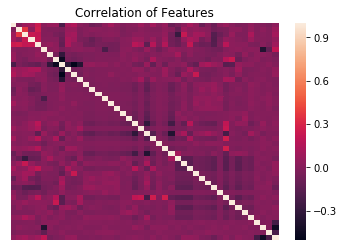

In [9]:
# Feature Correlation
ax = plt.axes();sns.heatmap(income_data.corr(), yticklabels=False, xticklabels=False)
ax.set_title('Correlation of Features');plt.show()

#### Evaluation Strategy
The clean dataset provides $\Phi$ with 43 features and over 30.000 observations. Assuming no causal inference from the model, one had to check for $2^{43}$ or roughly $8.8 \cdot 10^{12}$ models by brute force, which is computationally unfeasible. As we care only about the predictional power of our model, we could use the HS algorithm to find an optimal subset of the parameter space to predict the income group. 

For the evaluating the predictional power, the approach is to split the data in 3 sets. The third set contains 10% of the data and serves as test data. The other 90% will be split in 70% training data and 30% validation data, which will be used to evaluate the models during the asessment phase. All datasets are drawn with stratification ensuring the balance of presence for both income groups. Splitting the data in three parts is no issue as it contains over 30k observations.

To apply the algorithm a fitness function has to be defined to decide wheather a new combination of features enters the potential set of solutions. I tried various metrics (precision, accuracy, recall, etc.) related to the predictional power which tend return similar results as the AUC. Therefore, I will conduct the analysis for only two metrics as fitness functions for HS: 
- Minimizing the __AIC__ ensures a minimal model containing all relevant features trying to minimize the informational loss, calculated as follows: 
$$
L _ { \log } ( y , p ) = - \log \operatorname { Pr } ( y | p ) = - ( y \log ( p ) + ( 1 - y ) \log ( 1 - p ) )\\
AIC = 2 k - 2 L _ { \log } ( y , p )
$$
- Maximizing the __AUC__ ensures dececent predictional power of the model

When applying the HS, I will stick to the standard parameters which tend to deliver the best results as seen previously. The final models will be benchmarked against a random model and a statistical significant subset of the full model.

The number of features included in the model is reduced by almost 30%, while maintaining the predictional power of the model compared to the corrected full model. Both variants definitely outperform the random model. Interestingly the results do not much differ comparing the AIC and the AUC as fitness function.

In [10]:
# Data split
y = income_data.greater_fifty
income_data.drop(["greater_fifty"], axis=1,inplace=True)
X = income_data
X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.1, stratify= y)
X_train, X_valid, y_train, y_valid = train_test_split(X_tv, y_tv, test_size=0.3, stratify= y_tv)

In [11]:
# Benchmark model
logit = sm.Logit(y_tv, X_tv).fit(maxiter=1000, method= "minimize")
bench = list(logit.pvalues < 0.05)

Optimization terminated successfully.
         Current function value: 0.387624
         Iterations: 409
         Function evaluations: 410
         Gradient evaluations: 410


In [12]:
# Define metrics used as fitness function for HS
def fetch_logreg(indicator, X_training = X_train, y_training = y_train, X_validation = X_valid, 
                 y_validation = y_valid):
    indicator = [x==1 for x in indicator]
    X_training =  X_training.loc[::, indicator]
    X_validation = X_validation.loc[::, indicator]
    logreg = LogisticRegression(fit_intercept=True,C = 1e9)
    logreg.fit(X_training, y_training)
    prediction = pd.DataFrame(logreg.predict_proba(X_validation))[1]
    return prediction, y_validation

def get_AIC(indicator):
    y_hat, y_label = fetch_logreg(indicator)
    LL = - np.nansum(y_label * np.log(y_hat) + (1 - y_label)  * np.log(1 - y_hat))
    return (2 * sum([x==1 for x in indicator]) - 2 * LL)

def get_AUC(indicator):
    y_hat, y_label = fetch_logreg(indicator)
    return metrics.roc_auc_score(y_label, y_hat)

In [13]:
# Test model on the holdout dataset
def eval_logreg(indicator, X_training = X_tv, y_training = y_tv, X_validation = X_test, y_validation = y_test):
    indicator = [x==1 for x in indicator]
    X_training =  X_training.loc[::, indicator]
    X_validation = X_validation.loc[::, indicator]
    logreg = LogisticRegression(fit_intercept=True,C = 1e9)
    logreg.fit(X_training, y_training)
    prediction = pd.DataFrame(logreg.predict_proba(X_validation))[1]
    pred_labels = np.zeros(shape=(prediction.shape))
    pred_labels[prediction >= .5] = 1
    return prediction, y_validation, pred_labels

In [14]:
HMS1, HMS_fitness1, c1 = adapted_harmony_search(10, 43, get_AIC, NI=1000, maximize= False, seed=10)
HMS2, HMS_fitness2, c2 = adapted_harmony_search(10, 43, get_AUC, NI=1000, maximize= True,  seed=10, std = .0001)

In [15]:
# Number of variables included in each model
print(sum([x==1 for x in HMS1[HMS_fitness1.index(min(HMS_fitness1))]]))
print(sum([x==1 for x in HMS2[HMS_fitness2.index(min(HMS_fitness2))]]))

24
32


In [16]:
print(list(X_train.iloc[[x==1 for x in HMS1[HMS_fitness1.index(min(HMS_fitness1))]] ].columns.values))
print(list(X_train.iloc[[x==1 for x in HMS1[HMS_fitness2.index(min(HMS_fitness2))]] ].columns.values))

['age', 'family', 'male', 'hours_per_week', 'us_native', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'education_ 10th', 'education_ 11th', 'education_ 12th', 'education_ 5th-6th', 'education_ 7th-8th', 'education_ 9th', 'education_ Assoc-acdm', 'education_ Assoc-voc', 'education_ Bachelors', 'education_ Doctorate', 'education_ HS-grad', 'education_ Masters', 'education_ Preschool', 'education_ Prof-school', 'education_ Some-college', 'occupation_ Adm-clerical', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct', 'occupation_ Other-service', 'occupation_ Priv-house-serv', 'occupation_ Prof-specialty', 'occupation_ Protective-serv', 'occupation_ Sales', 'occupation_ Tech-support', 'occupation_ Transport-moving', 'race_ Amer-Indian-Eskimo', 'race_ Asian-Pac-Islander', 'race_ Oth

In [20]:
# Evaluate models on the holdout data
prediction1, labels1, pred_labels1 = eval_logreg(HMS1[HMS_fitness1.index(min(HMS_fitness1))])
prediction2, labels2, pred_labels2 = eval_logreg(HMS2[HMS_fitness2.index(max(HMS_fitness2))])
prediction3, labels3, pred_labels3 = eval_logreg(bench)
np.random.seed(9)
prediction4, labels4, pred_labels4 = eval_logreg(np.random.randint(0,2, 43))

In [21]:
# Classification report
print(metrics.classification_report(labels1, pred_labels1))
print(metrics.classification_report(labels2, pred_labels2))
print(metrics.classification_report(labels3, pred_labels3))
print(metrics.classification_report(labels4, pred_labels4))

             precision    recall  f1-score   support

          0       0.84      0.93      0.88      2305
          1       0.69      0.48      0.57       765

avg / total       0.81      0.82      0.80      3070

             precision    recall  f1-score   support

          0       0.85      0.92      0.88      2305
          1       0.67      0.50      0.57       765

avg / total       0.80      0.81      0.80      3070

             precision    recall  f1-score   support

          0       0.85      0.92      0.88      2305
          1       0.68      0.49      0.57       765

avg / total       0.80      0.82      0.80      3070

             precision    recall  f1-score   support

          0       0.78      0.96      0.86      2305
          1       0.60      0.17      0.26       765

avg / total       0.73      0.76      0.71      3070



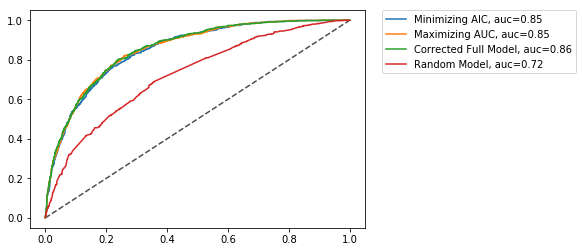

In [22]:
# Plotting ROC/ AUC
fpr1, tpr1, thresholds1 = metrics.roc_curve(labels1,  prediction1)
auc1 = metrics.roc_auc_score(labels1, prediction1)
fpr2, tpr2, thresholds2 = metrics.roc_curve(labels2,  prediction2)
auc2 = metrics.roc_auc_score(labels2, prediction2)
fpr3, tpr3, thresholds3 = metrics.roc_curve(labels3,  prediction3)
auc3 = metrics.roc_auc_score(labels3, prediction3)
fpr4, tpr4, thresholds4 = metrics.roc_curve(labels4,  prediction4)
auc4 = metrics.roc_auc_score(labels4, prediction4)
fig, ax = plt.subplots() 
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.plot(fpr1,tpr1,label="Minimizing AIC, auc="+str(round(auc1, 2)))
plt.plot(fpr2,tpr2,label="Maximizing AUC, auc="+str(round(auc2, 2)))
plt.plot(fpr3,tpr3,label="Corrected Full Model, auc="+str(round(auc3, 2)))
plt.plot(fpr4,tpr4,label="Random Model, auc="+str(round(auc4, 2)))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Conclusion
The HS algorithm can be applied to the problem of variable selection and delivers a decent performance under certain conditions. The most important condition for this procedure to work is that the fitness function is well defined. The conducted analysis has proven, that the algorithm performs well when applied to artificial and real data. 

The number of improvisations should be large, when applying the HS algorithm to obtian reliable results. Due to computational reasons the analysis is limited regarding the number of improvisations especially if the number of features exceeds the number of observations. In these settings the behaviour of the algorithm should be analyzed more carefully, but this is beyond the scope of this project. Additionally, other measures like Shannon's formula for uncertainty could be tested as a fitness function.

## References
1. Geem, Zong Woo, Joong Hoon Kim, and Gobichettipalayam Vasudevan Loganathan. "A new heuristic optimization algorithm: harmony search." simulation 76.2 (2001): 60-68
2. Alsewari, Abdul Rahman A., and Kamal Z. Zamli. "Design and implementation of a harmony-search-based variable-strength t-way testing strategy with constraints support." Information and Software Technology 54.6 (2012): 553-568
3. Omran, Mahamed GH, and Mehrdad Mahdavi. "Global-best harmony search." Applied mathematics and computation 198.2 (2008): 643-656
4. Manjarres, Diana, et al. "A survey on applications of the harmony search algorithm." Engineering Applications of Artificial Intelligence 26.8 (2013): 1818-1831
5. Bertsimas, Dimitris, Angela King, and Rahul Mazumder. "Best subset selection via a modern optimization lens." The annals of statistics 44.2 (2016): 813-852.
6. Burnham, K. P., & Anderson, D. R. (2004). Multimodel Inference: Understanding AIC and BIC in Model Selection. Sociological Methods & Research, 33(2), 261–304. https://doi.org/10.1177/0049124104268644
7. Hurvich, C. M.; Tsai, C.-L. (1989), "Regression and time series model selection in small samples", Biometrika 76: 297–307
8. Schneider, Thomas D. "Information theory primer." (1995): 370-379
9. Fawcett, Tom. "An introduction to ROC analysis." Pattern recognition letters 27.8 (2006): 861-874
10. Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science